<a href="https://colab.research.google.com/github/bongkyunSON/Deep_Leaning/blob/main/ARMA%2C_ARIMA_221211.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seasonal autoregressive integrated moving average

In [63]:
# import the packages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller #시계열 정상성 체크 모델
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10,6)

In [64]:
#read the data in a dataframe
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DeepLearning/prophet_강의/Part 1 데모용/AMAZON_stock.csv')
print(df.shape)

(1259, 7)


In [65]:
#inspect the dataframe
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-05-19,962.840027,968.919983,959.719971,959.840027,959.840027,3972100
1,2017-05-22,964.000000,971.380005,962.900024,970.669983,970.669983,2642200
2,2017-05-23,975.020020,975.200012,966.849976,971.539978,971.539978,2415600
3,2017-05-24,976.000000,981.000000,970.229980,980.349976,980.349976,2446000
4,2017-05-25,984.849976,999.000000,982.109985,993.380005,993.380005,4822000


In [66]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1254,2022-05-12,2055.000000,2215.610107,2048.110107,2138.610107,2138.610107,6601300
1255,2022-05-13,2181.379883,2263.679932,2156.000000,2261.100098,2261.100098,4676700
1256,2022-05-16,2262.000000,2279.850098,2207.080078,2216.209961,2216.209961,3728300
1257,2022-05-17,2265.500000,2316.000000,2225.530029,2307.370117,2307.370117,3822400
1258,2022-05-18,2228.790039,2257.060059,2124.979980,2142.250000,2142.250000,5404100


### Test for stationarity
Augmented Dicky-Fuller test:</br>
test statistic: stationary series are likely to have higher negative values </br>
null -hypothesis: presence of unit root (non-stationary) </br>


In [67]:
# do the statistical test for time series stationarity check
result = adfuller(df['Close'])

print(result[0], result[1]) # higher negative value of test statistic -> stationary
print('p-value:', result[1]) #p-value < 0.05

-1.567330798200027 0.4999804069946778
p-value: 0.4999804069946778


### Make the series stationary

In [68]:
# make a new column with logarithmic values closing price
df['log_close'] = np.log(df['Close'])

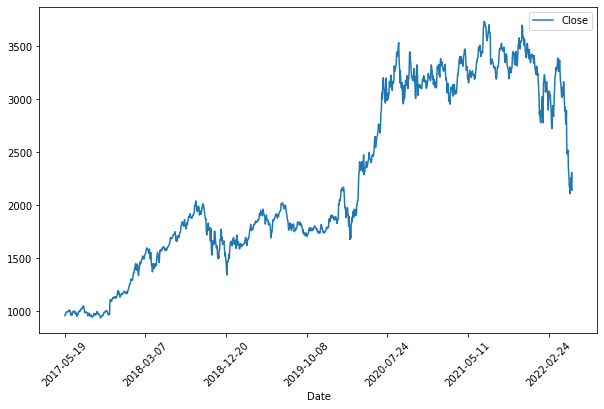

In [69]:
# plot with dates in x axis
df.plot(x='Date', y='Close')
plt.xticks(rotation=45)
plt.show()

In [70]:
# conduct stationarity test again
result = adfuller(df['log_close'])

print('test statistic :', result[0]) # higher negative value of test statistic -> stationary
print('p-value:', result[1]) #p-value < 0.05

test statistic : -1.8878019728567952
p-value: 0.33782102619716226


In [71]:
# make stationary using series differencing
amazon= df[['Date', 'log_close']]  # new dataframe with selected columns only
amazon_sarimax = df[['Date','log_close']]
amazon['diff_log_close'] = amazon['log_close'].diff().dropna()  
amazon_diff = amazon[['Date','diff_log_close']] 

<ipython-input-71-9a6485776a48>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon['diff_log_close'] = amazon['log_close'].diff().dropna()


In [72]:
# process the dataframes for different models
amazon_sarimax = df[['Date','log_close']]
amazon_prophet = df[['Date','log_close']]
amazon.drop('diff_log_close', axis=1, inplace=True)
amazon.set_index('Date', inplace=True)  # set the date column as index
amazon_diff.set_index('Date', inplace=True)
amazon_diff.dropna(inplace=True)
amazon_diff

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,diff_log_close
Date,
2017-05-22,0.011220
2017-05-23,0.000896
2017-05-24,0.009027
2017-05-25,0.013204
2017-05-26,0.002413
...,...
2022-05-12,0.014682
2022-05-13,0.055695
2022-05-16,-0.020053


In [73]:
# conduct stationarity test again
result = adfuller(amazon_diff['diff_log_close'])

# Print test statistic
print('statistic:', result[0],'\n', 'p-value:', result[1])

# Print test statistic
print('p-value:', np.round(result[1], 5))

statistic: -12.845118815143895 
 p-value: 5.501179656062845e-24
p-value: 0.0


p- value < 0.05 : rejects the null hypothesis

### Fit ARMA model

In [74]:
# Create ARMA(2,2) model
arma = SARIMAX(amazon_diff, order=(2,0,2))

# Fit model
arma_results = arma.fit()

# Print fit summary
print(arma_results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:         diff_log_close   No. Observations:                 1258
Model:               SARIMAX(2, 0, 2)   Log Likelihood                3098.433
Date:                Sun, 11 Dec 2022   AIC                          -6186.866
Time:                        05:51:59   BIC                          -6161.179
Sample:                             0   HQIC                         -6177.212
                               - 1258                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0580      1.334     -0.044      0.965      -2.673       2.556
ar.L2          0.2811      0.506      0.555      0.579      -0.711       1.273
ma.L1          0.0002      1.331      0.000      1.0

In [75]:
# use arma model to predict the stock price for the next 30 days
arma_diff_forecast = arma_results.get_forecast(steps=30).predicted_mean 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [76]:
arma_int_forecast = np.cumsum(arma_diff_forecast)

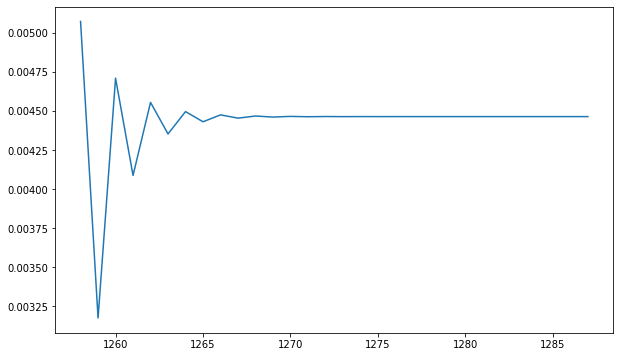

In [77]:
plt.plot(arma_int_forecast)

In [78]:
# addd this cumsum to the last value of the original time series
arma_value_forecast = arma_int_forecast + df[['log_close']].iloc[-1,0]

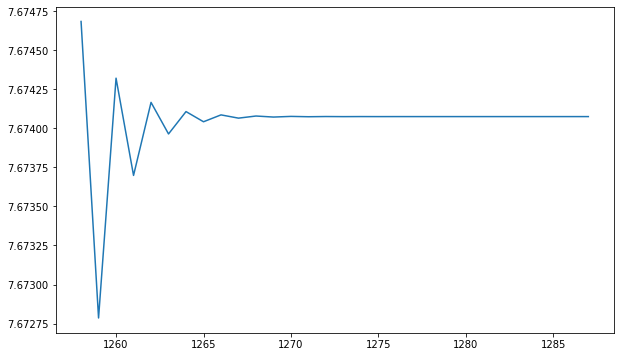

In [79]:
plt.plot(arma_value_forecast)

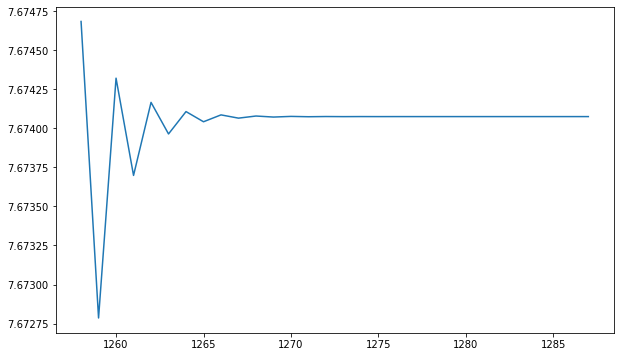

In [80]:
plt.plot(arma_value_forecast)

In [81]:
# Make arma forecast of next 30 differences
arma_diff_forecast = arma_results.get_forecast(steps=30).predicted_mean

# Integrate the difference forecast
arma_int_forecast = np.cumsum(arma_diff_forecast)


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [82]:
# Make absolute value forecast
arma_value_forecast = arma_int_forecast + amazon.iloc[-1,0]

# Print forecast
print(arma_value_forecast)

1258    7.674685
1259    7.672786
1260    7.674322
1261    7.673699
1262    7.674167
1263    7.673964
1264    7.674108
1265    7.674043
1266    7.674087
1267    7.674066
1268    7.674079
1269    7.674073
1270    7.674077
1271    7.674075
1272    7.674076
1273    7.674075
1274    7.674076
1275    7.674076
1276    7.674076
1277    7.674076
1278    7.674076
1279    7.674076
1280    7.674076
1281    7.674076
1282    7.674076
1283    7.674076
1284    7.674076
1285    7.674076
1286    7.674076
1287    7.674076
Name: predicted_mean, dtype: float64


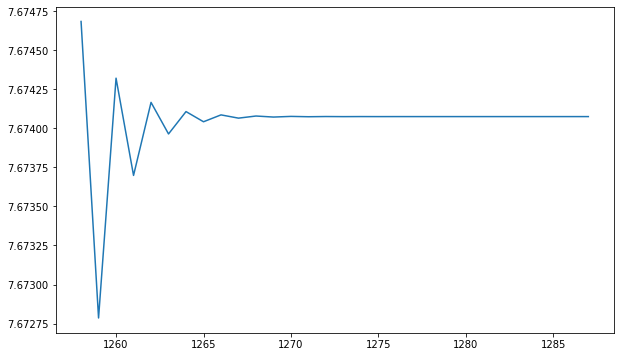

In [83]:
plt.plot(arma_value_forecast)

### Fit ARIMA model</br>
- helps to avoid the differencing and cumsum reversion

In [84]:
# Create ARIMA(2,1,2) model
arima = SARIMAX(amazon, order=(2,1,2))

# Fit ARIMA model
arima_results = arima.fit()

# Make ARIMA forecast of next 10 values
arima_value_forecast = arima_results.get_forecast(steps=30).predicted_mean

# Print forecast
print(arima_value_forecast)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


1259    7.674685
1260    7.672786
1261    7.674322
1262    7.673699
1263    7.674167
1264    7.673964
1265    7.674108
1266    7.674043
1267    7.674087
1268    7.674066
1269    7.674079
1270    7.674073
1271    7.674077
1272    7.674075
1273    7.674076
1274    7.674075
1275    7.674076
1276    7.674076
1277    7.674076
1278    7.674076
1279    7.674076
1280    7.674076
1281    7.674076
1282    7.674076
1283    7.674076
1284    7.674076
1285    7.674076
1286    7.674076
1287    7.674076
1288    7.674076
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


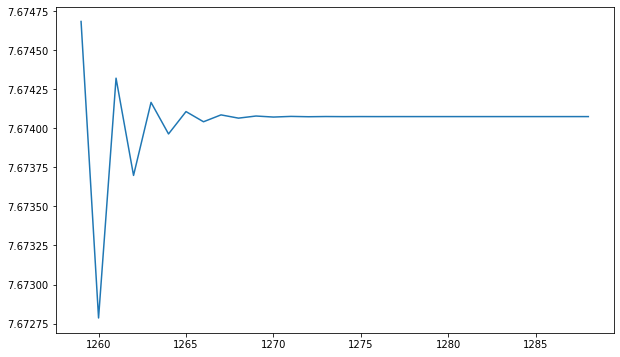

In [85]:
plt.plot(arima_value_forecast)

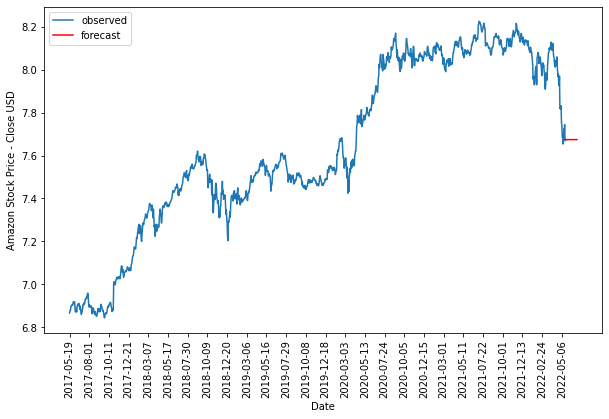

In [87]:
# plot the amazon data
plt.figure(figsize=(10,6))
plt.plot(amazon.index, amazon, label='observed')
# plot your mean predictions
plt.plot(arima_value_forecast.index, arima_value_forecast, color='r', label='forecast')
# set labels, legends and show plot
plt.xlabel('Date')
plt.xticks(amazon.index[::50],  rotation='vertical')
plt.ylabel('Amazon Stock Price - Close USD')
plt.legend()
plt.show()

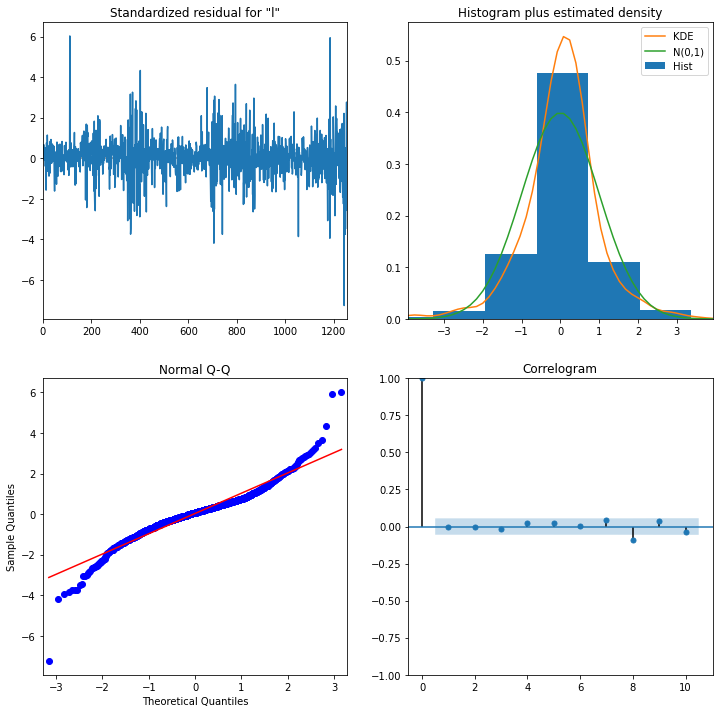

In [88]:
# Create the 4 diagostics plots
plt.rcParams['figure.figsize']=(12, 12)
arima_results.plot_diagnostics()
plt.show()

In [89]:
# model diagnostics

# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(arima_results.resid))

# Print mean absolute error
print(mae)

0.01970770491396915


### Fit a SARIMA model </br>
- takes care of seasonality


In [90]:
amazon

,log_close
Date,
2017-05-19,6.866767
2017-05-22,6.877987
2017-05-23,6.878882
2017-05-24,6.887910
2017-05-25,6.901113
...,...
2022-05-12,7.667911
2022-05-13,7.723607
2022-05-16,7.703554


In [91]:
amazon_sarimax['Date'] = pd.to_datetime(amazon_sarimax['Date'])
amazon_sarimax = amazon_sarimax.set_index('Date')
amazon_sarimax.dropna(inplace=True)
amazon_sarimax = amazon_sarimax.asfreq('D')

<ipython-input-91-13fd0dbb13fe>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amazon_sarimax['Date'] = pd.to_datetime(amazon_sarimax['Date'])


In [92]:
# Create a SARIMA model
model = SARIMAX(amazon, order=(1,0,0), seasonal_order=(1,1,0,7))

# Fit the model
results = model.fit()

# Print the results summary
print(results.summary())

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                                     SARIMAX Results                                     
Dep. Variable:                         log_close   No. Observations:                 1259
Model:             SARIMAX(1, 0, 0)x(1, 1, 0, 7)   Log Likelihood                2874.096
Date:                           Sun, 11 Dec 2022   AIC                          -5742.191
Time:                                   06:02:37   BIC                          -5726.794
Sample:                                        0   HQIC                         -5736.403
                                          - 1259                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9082      0.008    109.608      0.000       0.892       0.924
ar.S.L7       -0.4646      0.019    -23.826

In [93]:
sarima_forecast = results.get_forecast(steps=30).predicted_mean
sarima_forecast 

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


1259    7.613180
1260    7.608875
1261    7.626998
1262    7.673196
1263    7.635158
1264    7.658550
1265    7.601528
1266    7.578520
1267    7.567367
1268    7.589592
1269    7.645379
1270    7.620398
1271    7.655919
1272    7.594772
1273    7.559759
1274    7.554987
1275    7.578212
1276    7.632183
1277    7.603534
1278    7.635597
1279    7.578343
1280    7.550703
1281    7.544597
1282    7.568839
1283    7.624999
1284    7.599276
1285    7.634055
1286    7.576000
1287    7.545851
1288    7.541196
Name: predicted_mean, dtype: float64

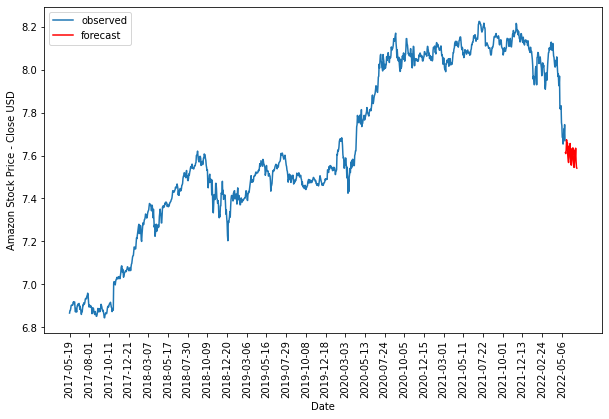

In [95]:
# plot the amazon data
plt.figure(figsize=(10,6))
plt.plot(amazon.index, amazon, label='observed')
# plot your mean predictions
plt.plot(sarima_forecast.index, sarima_forecast, color='r', label='forecast')
# set labels, legends and show plot
plt.xlabel('Date')
plt.xticks(amazon.index[::50],  rotation='vertical')
plt.ylabel('Amazon Stock Price - Close USD')
plt.legend()
plt.show()